In [18]:
using ModelingToolkit, OrdinaryDiffEq
using ModelingToolkit: t_nounits as t, D_nounits as D

using CoolProp.CoolProp: PropsSI
using BenchmarkTools
using Plots
using Suppressor

In [19]:
global fluid_name
fluid_name = "Parahydrogen";

In [20]:
# First define the temperature calculation function
function calc_T(h, p)
    return PropsSI("T", "H", h, "P", p, fluid_name)
end

# Register the function for symbolic use
@register_symbolic calc_T(h::Real, p::Real)


@connector FluidPort begin
    @variables begin
        h(t), [guess=0.0]
        p(t), [guess=0.0]
        ṁ(t), [guess=0.0, connect = Flow]
    end
end

@mtkmodel Source begin
    @parameters begin
        h_source
        p_source
        ṁ_source
    end

    @components begin
        outlet = FluidPort()
    end

    @equations begin
        outlet.h ~ h_source
        outlet.p ~ p_source
        outlet.ṁ ~ ṁ_source
    end
end

@mtkmodel Sink begin
    @components begin
        inlet = FluidPort()
    end
end

@mtkmodel Heater begin

    @components begin
        inlet = FluidPort()
        outlet = FluidPort()
    end

     @parameters begin
        T_Al         
        dL          
        UA_over_dL
    end

    @variables begin
        T(t)
        Q̇(t)
    end

    @equations begin
        T ~ calc_T(inlet.h, inlet.p)
        Q̇ ~ UA_over_dL*dL*(T_Al - T)
        outlet.h ~ inlet.h + Q̇/outlet.ṁ
        outlet.p ~ inlet.p
        outlet.ṁ + inlet.ṁ ~ 0 
    end
end

@component function HeatSystem(N_heaters; h_source, p_source, ṁ_source, T_Al, dL, UA_over_dL, name)

    pars = @parameters begin
        h_source = h_source
        p_source = p_source
        ṁ_source = ṁ_source
        T_Al = T_Al      
        dL = dL            
        UA_over_dL = UA_over_dL
    end

    ports = @named begin
        source = Source(h_source=h_source, p_source=p_source, ṁ_source=ṁ_source)
        sink = Sink()
    end
    
    heaters = []
    for i in 1:N_heaters
        x = Heater(; name=Symbol("heater$i"), 
           T_Al=ParentScope(T_Al), 
           dL=ParentScope(dL), 
           UA_over_dL=ParentScope(UA_over_dL))
        push!(heaters, x)
    end

    eqs = [
        connect(source.outlet, heaters[1].inlet)
        connect(heaters[end].outlet, sink.inlet)
    ]

    for i in 1:N_heaters-1
        push!(eqs, connect(heaters[i].outlet, heaters[i+1].inlet))
    end

    ODESystem(eqs, t, [], pars; name, systems=[ports; heaters])
end;

In [21]:
## Inputs
# Fluid parameters
ṁ = 10e-3            # kg/s
T_in = 70               # K
p_in = 350e5           # Pa
h_in = PropsSI("H", "T", T_in, "P", p_in, fluid_name);

# Wall parameters
T_Al = 50 + 273.15      # K
L = 10.0                 # m
dL = 0.1                # m
UA_over_dL = 100.0;
N_elements = Int(L/dL);

In [22]:
sys = @suppress begin
    @named sys_ = HeatSystem(N_elements; h_source=h_in, p_source=p_in, ṁ_source=ṁ,
    T_Al=T_Al, dL=dL, UA_over_dL=UA_over_dL)
    sys = structural_simplify(sys_)
end;

In [23]:
prob = ODEProblem(sys, [], (0, 10.0));

In [24]:
L_array, T_array = @btime begin
    
    sol = solve(prob, Tsit5())
    L_array = (1:N_elements)*dL
    T_array = [sol[getproperty(sys, Symbol("heater$i")).T][end] for i in 1:N_elements];

    return L_array, T_array
end;

  1.750 s (72555 allocations: 1.80 MiB)


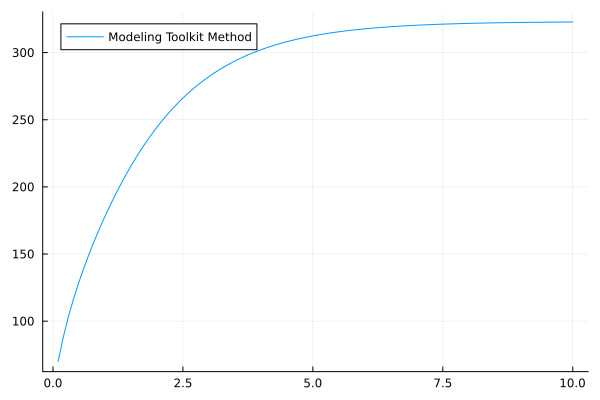

In [25]:
# Create comparison plot
p = plot(
    L_array, T_array,
    label="Modeling Toolkit Method"
)

display(p)